In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter
from pprint import pprint
import numpy as np
import pandas as pd
from datetime import datetime

from utils.dataloader import gen_dataloader_with_specified_train_val_data
from utils.model_manager import Manager
from models.cnn import SqueezedNet60, SqueezedNetLW60
from config.config import TransformParam, ConfDataloader

In [2]:
IMG_DIR_BASE = "./test_img_size60/cam2/"

# train data ==================================
train_data_dir = [
    "deta_aug_basic_20200601_lab_0-01",
    "deta_aug_basic_20200601_lab_1-01",
    "deta_aug_basic_20200601_lab_2-01",
]
train_data_dir = [IMG_DIR_BASE + d for d in train_data_dir]
train_labels = ["0", "1", "2"]


# val data ====================================
val_data_dir = [
    "2020-06-02/cam2/cam2_0_0",
    "2020-06-02/cam2/cam2_0_1",
    "2020-06-02/cam2/cam2_0_2",
    "2020-06-03/cam2/cam2_0_0",
    "2020-06-03/cam2/cam2_0_1",
    "2020-06-03/cam2/cam2_0_2",
]
val_data_dir = [IMG_DIR_BASE + d for d in val_data_dir]
val_labels = ["0", "1", "2"] + ["0", "1", "2"]


In [3]:
dataloader, data_descriptions = gen_dataloader_with_specified_train_val_data(
    train_data_dir=train_data_dir, 
    train_labels=train_labels, 
    val_data_dir=val_data_dir, 
    val_labels=val_labels)

# print(dataloader.dataset.label_idx_dict)
pprint(data_descriptions)

{'class': {'0', '2', '1'},
 'class_num': 3,
 'data_num': {'test': {'0': 181, '1': 780, '2': 83},
              'train': {'0': 585, '1': 953, '2': 760}}}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


data index: 10/2298
label_index: 2
label: 1
torch.Size([3, 60, 60])


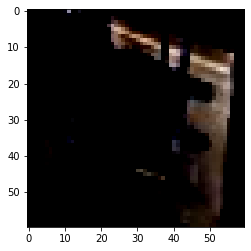

In [4]:
index = 10
mode = "train"

x, y = dataloader.set_mode(mode=mode).dataset.__getitem__(index=index)

print(f"data index: {index}/{dataloader.dataset.__len__()}")
print(f"label_index: {y}")
print(f"label: {dataloader.dataset.label_idx2label(label_index=y.item())}")
print(x.size())

arr_x = np.squeeze(x.numpy().transpose((1, 2, 0)))
plt.imshow(arr_x)

In [5]:
model = SqueezedNetLW60(
    d_params={
        "dropout": 0.3,
        "class_num": data_descriptions["class_num"]})
model.model_descriptions()

{'name': 'SqueezedNetLW60',
 'input_size': 60,
 'input_channel': 3,
 'params': {'dropout': 0.3, 'class_num': 3}}

In [6]:
model

SqueezedNetLW60(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Fire(
      (squeeze): Sequential(
        (0): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (expand1x1): Sequential(
        (0): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (expand3x3): Sequential(
        (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReL

In [7]:
manager = Manager(model=model)
manager.train(
    num_epochs=50, 
    dataloader=dataloader, 
    print_epoch_step=int(5),
    auto_save=True)
plt.close()

Training: SqueezedNetLW60 20220430005026
batch size: 8

Epoch:5/50 ============
    Mode: train, Loss: 0.5744, Acc: 0.9098
    Mode: test, Loss: 0.2142, Acc: 0.9971
Epoch:10/50 ============
    Mode: train, Loss: 0.3306, Acc: 0.9521
    Mode: test, Loss: 0.0657, Acc: 0.9971
Epoch:15/50 ============
    Mode: train, Loss: 0.2432, Acc: 0.9573
    Mode: test, Loss: 0.0224, Acc: 0.9971
Epoch:20/50 ============
    Mode: train, Loss: 0.1472, Acc: 0.9769
    Mode: test, Loss: 0.0206, Acc: 0.9952
Epoch:25/50 ============
    Mode: train, Loss: 0.1339, Acc: 0.9765
    Mode: test, Loss: 0.0138, Acc: 0.9962
Epoch:30/50 ============
    Mode: train, Loss: 0.1068, Acc: 0.9817
    Mode: test, Loss: 0.0062, Acc: 0.999
Epoch:35/50 ============
    Mode: train, Loss: 0.1133, Acc: 0.983
    Mode: test, Loss: 0.0051, Acc: 0.999
Epoch:40/50 ============
    Mode: train, Loss: 0.0943, Acc: 0.9852
    Mode: test, Loss: 0.0053, Acc: 0.9971
Epoch:45/50 ============
    Mode: train, Loss: 0.0801, Acc: 0.9817


c:\users\arimu\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


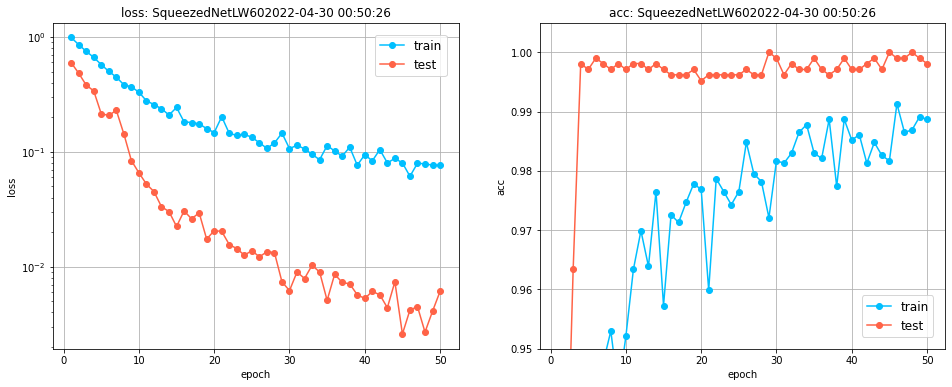

In [8]:
result_fig = manager.make_result_fig()
result_fig.show()

In [ ]:
# incorrect prediction ===

import os

dataloader.set_mode(mode="test")
for index in range(dataloader.dataset.__len__()):
    
    fn, label = dataloader.dataset.get_filename_label(index=index)
    pred = manager.predict(fpath=fn)
    if label != pred:
        print(f"file: {os.path.basename(fn)}, label: {label}, prediction: {pred}")